Pix2Pix使用了CGAN的思路，修改网络结构为U-Net，损失函数中加入L1 loss，即为Pix2Pix的特点。  

模型资源 https://github.com/affinelayer/pix2pix-tensorflow

#### CGAN输入
待翻译的图像x与加在x之上的随机噪声z。生成器工作如下：
$$
G:\{x, z\} \rightarrow y
$$

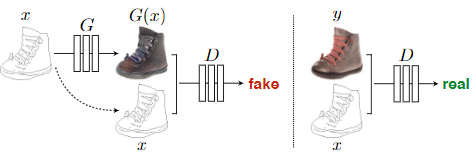

#### U-Net generator

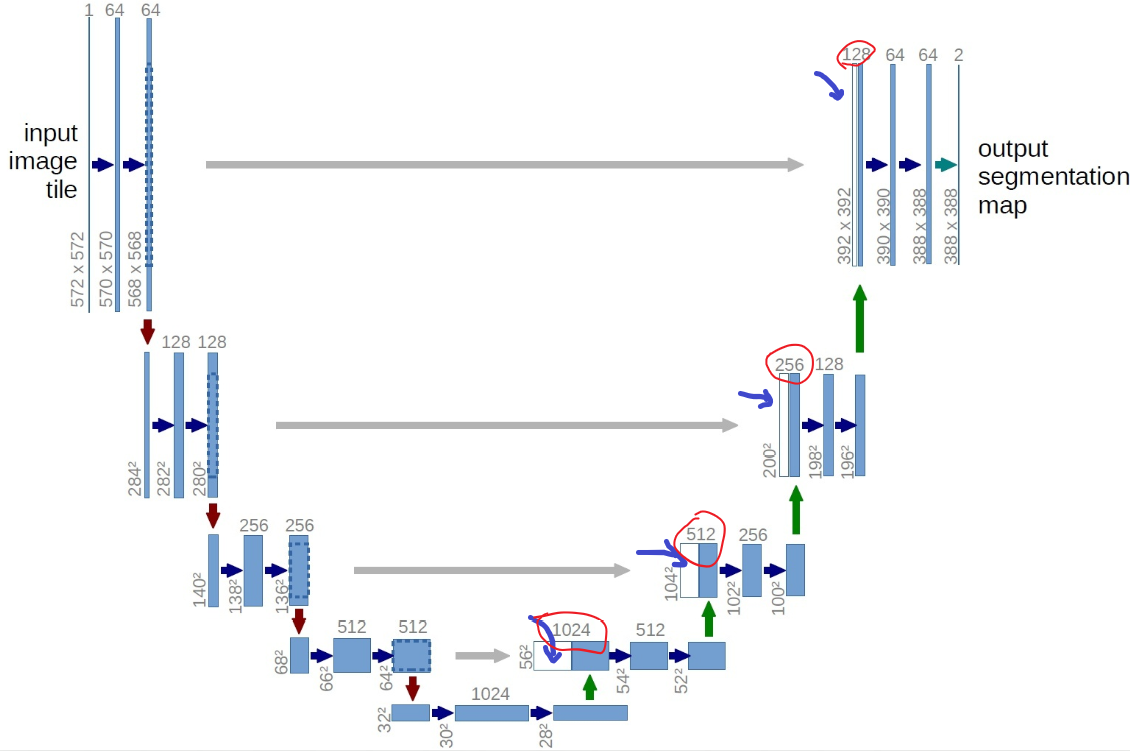

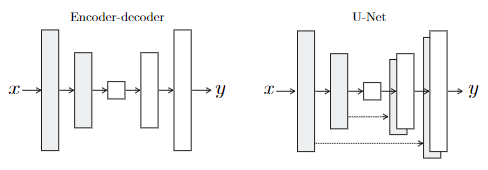

encoder-decoder，对称结构， skip  connections将对应encoder layer拼接到decoder层。

#### L1 loss

$$
\begin{aligned} \mathcal{L}_{c G A N}(G, D)=& \mathbb{E}_{x, y}[\log D(x, y)]+\\ & \mathbb{E}_{x, z}[\log (1-D(x, G(x, z))]\end{aligned}
$$

$$
\begin{aligned} \mathcal{L}_{G A N}(G, D)=& \mathbb{E}_{y}[\log D(y)]+\\ & \mathbb{E}_{x, z}[\log (1-D(G(x, z))]\end{aligned}
$$

$$
\mathcal{L}_{L 1}(G)=\mathbb{E}_{x, y, z}\left[\|y-G(x, z)\|_{1}\right]
$$

$$
G^{*}=\arg \min _{G} \max _{D} \mathcal{L}_{c G A N}(G, D)+\lambda \mathcal{L}_{L 1}(G)
$$

使用之后，效果提升
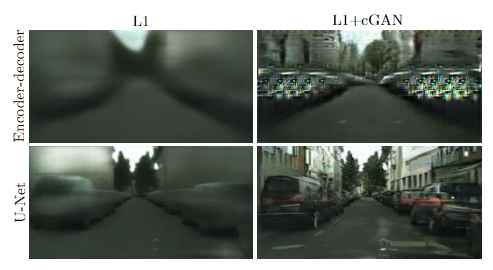

L1 loss使得图像在学习中，低频的信息得以保留。

同时在计算整张图片的discriminator prediction时，将图片划分为不同的小块，分别计算得分，即PatchGAN方法。论文中给出的理由是，PatchGAN训练难度会低一些，参数少一些。结果的却更好一些，图像也更平滑一些。

PatchGAN实现方法，就是加一层1 * 1 conv层，利用卷积自身的特点，分块计算。

相当于以前flatten特征图 + fc层的方法，变成conv层来完成。

### Code

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import glob
import os
from tqdm import tqdm

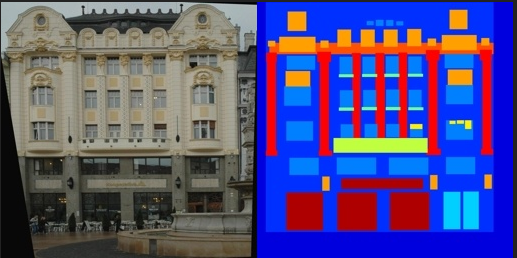

In [ ]:
# data
images = glob.glob('data/train/*.jpg') + glob.glob('data/val/*.jpg')
print(len(images))

# 分离图片数据中的左右两部分
X_all = []
Y_all = []
WIDTH = 256
HEIGHT = 256

for image in images:
    img = imread(image)
    img = (img / 255. - 0.5) * 2

    X_all.append(img[:, WIDTH:, :])
    Y_all.append(img[:, :WIDTH, :])

X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

In [ ]:
batch_size = 1
LAMBDA = 100

OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# 注，可以在X上，加入random noise Z
X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='Y')

k_initializer = tf.random_normal_initializer(0, 0.02)  # conv参数初始化
g_initializer = tf.random_normal_initializer(1, 0.02)  # batch norm参数初始化

#### layers

In [ ]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)


def d_conv(inputs, filters, strides):
    padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
    return tf.layers.conv2d(padded,
                            kernel_size=4,
                            filters=filters,
                            strides=strides,
                            padding='valid',
                            kernel_initializer=k_initializer)


def g_conv(inputs, filters):
    # U-net encoder
    return tf.layers.conv2d(inputs,
                            kernel_size=4,
                            filters=filters,
                            strides=2,
                            padding='same',
                            kernel_initializer=k_initializer)


def g_deconv(inputs, filters):
    # U-net decoder
    return tf.layers.conv2d_transpose(inputs,
                                      kernel_size=4,
                                      filters=filters,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=k_initializer)


def batch_norm(inputs):
    return tf.layers.batch_normalization(inputs,
                                         axis=3,
                                         epsilon=1e-5,
                                         momentum=0.1,
                                         training=True,
                                         gamma_initializer=g_initializer)


def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)

#### Model

In [ ]:
def discriminator(x, y, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.concat([x, y], axis=3)
        h0 = lrelu(d_conv(x, 64, 2))  # 128 128 64

        h0 = d_conv(h0, 128, 2)
        h0 = lrelu(batch_norm(h0))  # 64 64 128

        h0 = d_conv(h0, 256, 2)
        h0 = lrelu(batch_norm(h0))  # 32 32 256

        h0 = d_conv(h0, 512, 1)
        h0 = lrelu(batch_norm(h0))  # 31 31 512

        # patch gan，conv代替fc
        h0 = d_conv(h0, 1, 1)  # 30 30 1
        h0 = tf.nn.sigmoid(h0)

        return h0

In [ ]:
def generator(x):
    with tf.variable_scope('generator', reuse=None):
        # 保留，用作skip connection
        layers = []
        h0 = g_conv(x, 64)
        layers.append(h0)

        # encoder
        for filters in [128, 256, 512, 512, 512, 512, 512]:
            h0 = lrelu(layers[-1])
            h0 = g_conv(h0, filters)
            h0 = batch_norm(h0)
            layers.append(h0)

        encode_layers_num = len(layers)  # 8

        # decoder
        for i, filters in enumerate([512, 512, 512, 512, 256, 128, 64]):
            # 取相应层
            skip_layer = encode_layers_num - i - 1
            if i == 0:
                inputs = layers[-1]
            else:  # 下一层输入，skip connection
                inputs = tf.concat([layers[-1], layers[skip_layer]], axis=3)

            h0 = tf.nn.relu(inputs)
            h0 = g_deconv(h0, filters)
            h0 = batch_norm(h0)

            if i < 3:
                h0 = tf.nn.dropout(h0, keep_prob=0.5)
            layers.append(h0)

        inputs = tf.concat([layers[-1], layers[0]], axis=3)

        h0 = tf.nn.relu(inputs)
        h0 = g_deconv(h0, 3)
        h0 = tf.nn.tanh(h0, name='g')

        return h0

#### Loss

In [ ]:
g = generator(X)
d_real = discriminator(X, Y)
d_fake = discriminator(X, g, reuse=True)

vars_g = [
    var for var in tf.trainable_variables() if var.name.startswith('generator')
]
vars_d = [
    var for var in tf.trainable_variables()
    if var.name.startswith('discriminator')
]

loss_d_real = tf.reduce_mean(
    sigmoid_cross_entropy_with_logits(d_real, tf.ones_like(d_real)))
loss_d_fake = tf.reduce_mean(
    sigmoid_cross_entropy_with_logits(d_fake, tf.zeros_like(d_fake)))
loss_d = loss_d_real + loss_d_fake

loss_g_gan = tf.reduce_mean(
    sigmoid_cross_entropy_with_logits(d_fake, tf.ones_like(d_fake)))
# L1 loss
loss_g_l1 = tf.reduce_mean(tf.abs(Y - g))
loss_g = loss_g_gan + loss_g_l1 * LAMBDA

# 分别更新D与G
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002,
                                         beta1=0.5).minimize(loss_d,
                                                             var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002,
                                         beta1=0.5).minimize(loss_g,
                                                             var_list=vars_g)

#### train

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss = {'d': [], 'g': []}

for i in tqdm(range(100000)):
    k = i % X_all.shape[0]
    X_batch, Y_batch = X_all[k:k + batch_size, :, :, :], Y_all[k:k + batch_size, :, :, :]

    _, d_ls = sess.run([optimizer_d, loss_d],
                       feed_dict={
                           X: X_batch,
                           Y: Y_batch
                       })
    _, g_ls = sess.run([optimizer_g, loss_g],
                       feed_dict={
                           X: X_batch,
                           Y: Y_batch
                       })

    loss['d'].append(d_ls)
    loss['g'].append(g_ls)

    if i % 1000 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={X: X_batch})
        
        result = np.zeros([HEIGHT, WIDTH * 3, 3])
        result[:, :WIDTH, :] = (X_batch[0] + 1) / 2
        result[:, WIDTH:2 * WIDTH, :] = (Y_batch[0] + 1) / 2
        result[:, 2 * WIDTH:, :] = (gen_imgs[0] + 1) / 2
        
        plt.axis('off')
        plt.imshow(result)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), result)
        plt.show()
    
saver = tf.train.Saver()
saver.save(sess, './pix2pix_diy', global_step=100000)

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()

#### Test

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave
import glob

In [2]:
images = glob.glob('data/val/*.jpg')
X_all = []
Y_all = []
WIDTH = 256
HEIGHT = 256
N = 10

images = np.random.choice(images, N, replace=False)
for image in images:
    img = imread(image)
    img = (img / 255. - 0.5) * 2

    X_all.append(img[:, WIDTH:, :])
    Y_all.append(img[:, :WIDTH, :])

X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

(10, 256, 256, 3) (10, 256, 256, 3)


INFO:tensorflow:Restoring parameters from ./pix2pix_diy-100000


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


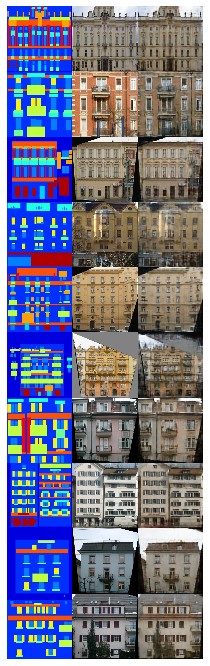

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('./pix2pix_diy-100000.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))

graph = tf.get_default_graph()
g = graph.get_tensor_by_name('generator/g:0')
X = graph.get_tensor_by_name('X:0')

gen_imgs = sess.run(g, feed_dict={X: X_all})
result = np.zeros([N * HEIGHT, WIDTH * 3, 3])

for i in range(N):
    result[i * HEIGHT: i * HEIGHT + HEIGHT, :WIDTH, :] = (X_all[i] + 1) / 2
    result[i * HEIGHT: i * HEIGHT + HEIGHT, WIDTH: 2 * WIDTH, :] = (Y_all[i] + 1) / 2
    result[i * HEIGHT: i * HEIGHT + HEIGHT, 2 * WIDTH:, :] = (gen_imgs[i] + 1) / 2

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(result)
imsave('val.jpg', result)
plt.show()